# Artificial Intelligence Systems Lab 5


---
### Задание 1
    Для студентов с нечетным порядковым номером в группе датасет с данными про оценки студентов инженерного и педагогического факультетов (для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда)
---

In [133]:
import pandas as pd

data = pd.read_csv("OLD_DATA.csv")

success_threshold = 3
data['successful'] = data['GRADE'].apply(lambda x: 1 if x >= success_threshold else 0)

data.to_csv("DATA.csv", index=False)
data

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,COURSE ID,GRADE,successful
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,3,2,1,2,1,1,1,1,0
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,3,2,3,2,2,3,1,1,0
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,2,2,1,1,2,2,1,1,0
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,2,3,2,2,1,3,2,1,1,0
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,1,2,2,2,1,2,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,2,1,2,1,3,3,9,5,1
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,3,2,2,1,5,3,9,5,1
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,3,3,2,1,4,3,9,1,0
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,1,2,1,2,1,5,3,9,4,1


---
### Задание 2

    Отобрать случайным образом sqrt(n) признаков
---

In [134]:
import pandas as pd
import numpy as np

data = pd.read_csv("DATA.csv")

columns_to_exclude = ['STUDENT ID', 'COURSE ID']
features = data.drop(columns=columns_to_exclude)

n = len(features.columns)
num_features = int(np.sqrt(n))

# selected_features = np.random.choice(features.columns, num_features, replace=False)
selected_features = ['16', '25', '21', '29', '2']
selected_data = data[selected_features]

# print(f"Selected features: {selected_features}")
selected_data

,16,25,21,29,2
0,5,3,1,1,2
1,1,3,1,2,2
2,1,2,1,2,2
3,1,3,1,3,1
4,4,2,1,2,2
...,...,...,...,...,...
140,4,2,1,3,1
141,1,3,1,5,1
142,4,3,1,4,1
143,3,2,1,5,1


---
### Задание 3
    Реализовать без использования сторонних библиотек построение дерева решений (дерево не бинарное, numpy и pandas использовать можно) для решения задачи бинарной классификации
---

In [135]:
import pandas as pd

data = pd.read_csv('DATA.csv')

target = [row[-1] for row in data.values]
target_classes = set(target)
columns_to_exclude = ['STUDENT ID', 'COURSE ID', 'GRADE', 'successful']
data = data.drop(columns_to_exclude, axis=1)
selected_features = ['16', '25', '21', '29', '2']
data = data[selected_features]


def target_entropy():
    total = len(target)
    classes = set(target)
    return sum([-(target.count(c) / total) * np.log2(target.count(c) / total) for c in classes])


def entropy_info(column):
    total = len(column)
    classes = set(column)
    res = 0
    for c in classes:
        ent = 0
        c_total = column.tolist().count(c)
        for t in target_classes:
            prob = sum(1 for a, b in zip(column.tolist(), target) if a == c and b == t) / c_total
            ent -= prob * np.log2(prob) if prob != 0 else 0
        res += (c_total / total) * ent

    return res


def information_gain(column):
    return target_entropy() - entropy_info(column)


def split_info(column):
    total = len(column)
    classes = set(column)
    return sum([-(column.tolist().count(c) / total) * np.log2(column.tolist().count(c) / total) for c in classes])


def gain_ratio(column):
    return information_gain(column) / split_info(column) if split_info(column) != 0 else 0


def build_tree(data, target):
    if len(set(target)) == 1:
        return {'success' if target[0] == 1 else 'fail': 1.0}

    if data.empty:
        total = len(target)
        success_prob = target.count(1) / total
        fail_prob = target.count(0) / total
        return {'success': success_prob, 'fail': fail_prob}

    gain_ratios = {col: gain_ratio(data[col]) for col in data.columns}

    best_attribute = max(gain_ratios, key=gain_ratios.get)

    tree = {best_attribute: {}}

    for value in set(data[best_attribute]):
        subset_data = data[data[best_attribute] == value].drop(columns=[best_attribute])
        subset_target = [t for d, t in zip(data[best_attribute], target) if d == value]

        tree[best_attribute][value] = build_tree(subset_data, subset_target)

    return tree

---
### Задание 4
    Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall
---

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


def predict(tree, sample, threshold=0.5):
    if isinstance(tree, dict):
        if len(tree) == 1 and ('success' in tree or 'fail' in tree):
            success_prob = tree.get('success', 0)
            fail_prob = tree.get('fail', 0)

            if success_prob > fail_prob:
                return 1
            else:
                return 0
        elif len(tree) == 2:
            if (list(tree.keys())[0] == 'success' or list(tree.keys())[0] == 'fail') and (
                    list(tree.keys())[1] == 'success' or list(tree.keys())[1] == 'fail'):
                success_prob = tree.get('success', 0)
                fail_prob = tree.get('fail', 0)

                if success_prob > fail_prob:
                    return 1
                else:
                    return 0

    attribute = next(iter(tree))
    value = sample[attribute]
    # print(f'Attribute: {attribute}, Sample value and sample: {value} -> {sample}')

    if value in tree[attribute]:
        return predict(tree[attribute][value], sample)
    else:
        return None


def evaluate_model(tree, data, target):
    samples = data.to_dict(orient='records')
    pred = [predict(tree, sample) for sample in samples]
    return pred


tree = build_tree(data, target)

pred = evaluate_model(tree, data, target)

accuracy = accuracy_score(target, pred)
precision = precision_score(target, pred, average='weighted', zero_division=0)
recall = recall_score(target, pred, average='weighted', zero_division=0)

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall
}
print("Результаты оценки:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Результаты оценки:
Accuracy: 0.8552
Precision: 0.8576
Recall: 0.8552


---
### Задание 5
    Построить кривые AUC-ROC и AUC-PR
---

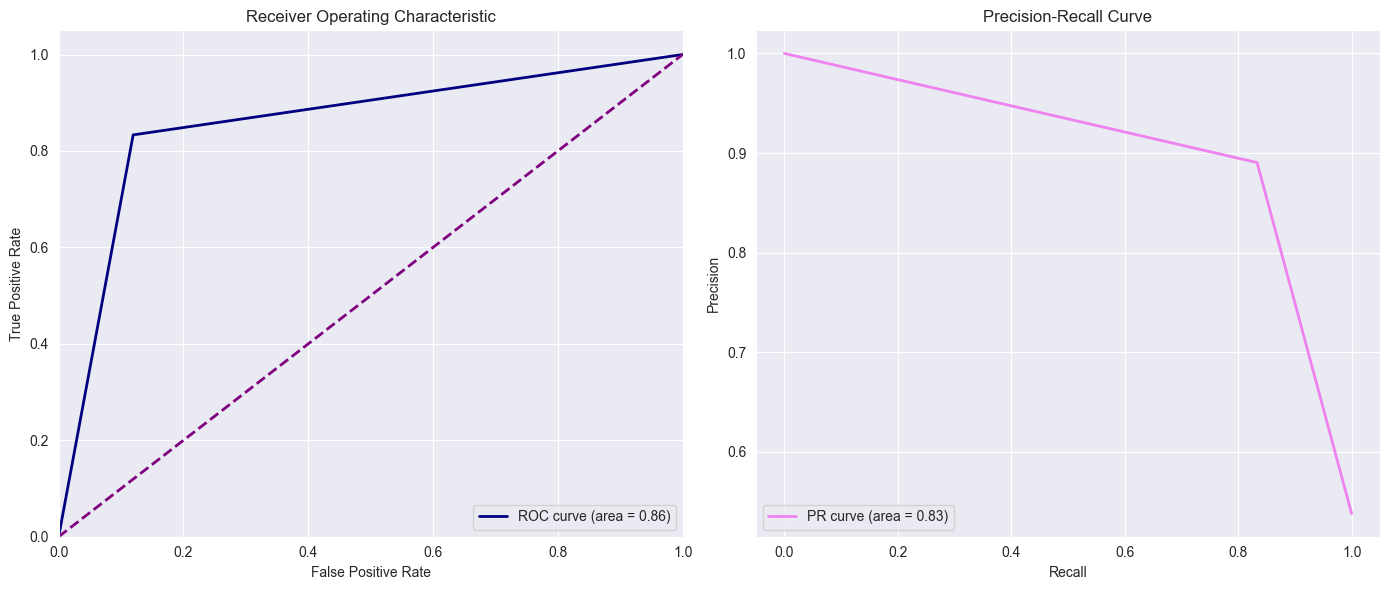

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_true = target
y_pred = evaluate_model(tree, data, target)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))  

ax[0].plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, color='violet', lw=2, label='PR curve (area = %0.2f)' % auc_pr)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc='lower left')

plt.tight_layout()  
plt.show()

ROC-кривая:

    Показывает общую способность модели различать классы.
    Подходит для сбалансированных данных.

PR-кривая:

    Сфокусирована на положительном классе.
    Полезна при несбалансированных данных (редкие события).

Accuracy:
    
    Accuracy показывает, какую долю всех предсказаний модель сделала правильно.
    
Precision:

    Precision показывает, как много из предсказанных моделью положительных объектов действительно принадлежат положительному классу.
    
Recall:

    Recall показывает, какую долю из всех положительных объектов модель смогла правильно классифицировать.
   